In [108]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', )))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker

import seaborn as sns

from config_colors import *
from config_paths import *
from config_plot_params import *
from nwb_io import *

from tabulate import tabulate
from nilearn.plotting import plot_markers

import binning_isolated_from_db as binning

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.8f}'.format)

# save panels directly to the relevant svg/ subdir
panel_save_dir = Path.cwd().parent.parent / "figure_generation" / "figure_spike_sorting" / "svg"

data_dir = NWB_data_dir

In [8]:
patient_id = 92

path = f"/media/al/Seagate/refractored_data/patient_data/{patient_id}/session_1/sub{patient_id}.nwb"
print(f"  {patient_id}")
io = NWBHDF5IO(path, mode="r")
nwbfile = io.read()

  92


In [2]:
subdivide = None
small_bin_length = None
bin_length = 1000

pat_subset = [14,20,23,28,30,31,33,39,41,42,
              44,50,52,53,60,61,64,65,66,68,
              73,83,87,88,89,90,92,96,98]

i=0

units_per_channel = []
region_for_channel = []

for patient_id in pat_subset:

    path = data_dir / f"sub{patient_id}.nwb"
    print(f"  {patient_id}")
    io = NWBHDF5IO(path, mode="r")
    nwbfile = io.read()

    print("  converting spikes to dataframe..")
    df_units = nwbfile.units.to_dataframe()
    df_units["unit_id"] = np.arange(0, len(df_units))

    df_units.insert(0, "patient_id", [patient_id] * len(df_units), )

    ### calculate firing rate
    movie_edges_all = nwbfile.stimulus["movie_binning_info"].to_dataframe()
    movie_edges = movie_edges_all[movie_edges_all["bin_length"] == bin_length]["edges"].iloc[0]

    spikes = df_units["spike_times"]

    wl = nwbfile.stimulus["cleaned_watchlogs"].to_dataframe()
    patient_rec = wl["neural_recording_time"].to_numpy()
    patient_pts = wl["pts"].to_numpy()

    res = binning.bin_spikes_with_movie_edges(bin_length, spikes, movie_edges, patient_rec, patient_pts, subdivide, small_bin_length)
    
    fr_hz = np.mean(res, axis=1)
    df_units.insert(len(df_units.columns) - 1, "fr_hz", fr_hz)
    ###

    ### grab number of units per channel
    channel_names = nwbfile.ec_electrode_groups.keys()
    nm_total_channels = len(channel_names) * 8

    electrode_df = nwbfile.ec_electrodes.to_dataframe()

    for id, row in electrode_df.iterrows():
        csc_nr = row.csc_nr
        brain_region = row.brain_region

        mask = df_units["csc_nr"] == csc_nr
        filtered_df = df_units[mask]
        nm_units_in_channel = len(filtered_df)

        units_per_channel.append(nm_units_in_channel)
        region_for_channel.append(brain_region)
    ###


    if i == 0:
        df_units_all = df_units.copy()
    else:
        df_units_all = pd.concat([df_units_all, df_units], ignore_index=True)
    
    io.close()
    i += 1



df_units_all = df_units_all[df_units_all["brain_region"] != "I"]
df_units_all = df_units_all[df_units_all["brain_region"] != "T"]
df_units_all["brain_region"] = df_units_all["brain_region"].replace(["AH", "MH", "PH"], "H",)


units_per_channel = np.array(units_per_channel)
region_for_channel = np.array(region_for_channel)

df_channelwise_units = pd.DataFrame({
    "channel_count": units_per_channel,
    "channel_region": region_for_channel, 
})

df_channelwise_units["channel_region"] = df_channelwise_units["channel_region"].replace(["AH", "MH", "PH"], "H",)




  14
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (40, 4726)
*** BINNING ENDS ***

  20
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (83, 4726)
*** BINNING ENDS ***

  23
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (51, 4726)
*** BINNING ENDS ***

  28
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (120, 4726)
*** BINNING ENDS ***

  30
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (79, 4726)
*** BINNING ENDS ***

  31
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (99, 4726)
*** BINNING ENDS ***

  33
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (84, 4726)
*** BINNING ENDS ***

  39
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (45, 4726)
*** BINNING ENDS ***

  41
  converting spikes to dataframe..
*** BINNING STARTS ***
Final res shape: (41, 4726)
*** 

In [70]:
df_channelwise_units["channel_region"] = df_channelwise_units["channel_region"].replace({
    "PIC": "Other",
    "FF": "Other",
    "LG": "Other",
    "FF": "Other",
    "PRC": "Other",
})

df_units_all["brain_region"] = df_units_all["brain_region"].replace({
    "PIC": "Other",
    "FF": "Other",
    "LG": "Other",
    "FF": "Other",
    "PRC": "Other",
})

In [174]:
## plot params

lw_cdf = 3
lw_summary_stat = 3
b = 25

stat_line_color = "dimgrey"

title_size_subplot = 16
label_size = 14
tick_size = 12

# data processing 

## units per channel
def channelwise_hists_for_a_region(df_channelwise_units, region, bins):
    mask = df_channelwise_units["channel_region"] == region
    region_channels = df_channelwise_units[mask]
    hists, _ = np.histogram(region_channels["channel_count"].to_numpy(), bins)
    return hists

def cdf_regionwise_channels(df_channelwise_units, bins):
    regions = np.unique(df_channelwise_units["channel_region"])
    return {r: apply_cdf(channelwise_hists_for_a_region(df_channelwise_units, r, bins)) for r in regions}

def data_units_per_channel(df_channelwise_units, bins=25):
    hist, bin_edges = np.histogram(df_channelwise_units["channel_count"], bins)

    regions_cdf_dict = cdf_regionwise_channels(df_channelwise_units, bins)
    return hist, bin_edges, regions_cdf_dict


## other metrics/amounts
def filter_df_column_by_region(df_units_all: pd.DataFrame, column: str, region: str, bins: int, log: bool):
    mask = df_units_all["brain_region"] == region
    df_region_restricted = df_units_all[mask]

    nan_mask = ~np.isnan(df_region_restricted[column])
    df_region_data = df_region_restricted[nan_mask]

    if log: 
        data = np.log10(df_region_data[column])
    else:
        data = df_region_data[column].to_numpy()

    hists, _ = np.histogram(data, bins)
    return hists

def cdf_regionwise_metrics(df_units_all, column, bins, log=False):
    regions = np.unique(df_units_all["brain_region"])
    return {r: apply_cdf(filter_df_column_by_region(df_units_all, column, r, bins, log)) for r in regions}

def no_nan_histogram(metric_array, b):
    data = metric_array[~np.isnan(metric_array)]
    hists, bin_edges = np.histogram(data, b)
    return hists, bin_edges

def count_su_mu(df_units_all):
    su = sum(df_units_all["single_unit"])
    mu = len(df_units_all) - su
    return su, mu

### stats


def apply_cdf(data):
    pdf = data / data.sum()
    return np.cumsum(pdf) * 100


### plotting
def plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_all_regions, color_dict=color_by_region):
    ## plot histogram for all data
    ax0.bar(bin_edges[:-1], hists, width=np.diff(bin_edges), align='edge', edgecolor='white')

    ## plot region-stratified cdf
    order = ["A", "H", "EC", "PHC", "Other"]
    #for key, item in cdf_all_regions.items():
    for key in order:
        item = cdf_all_regions[key]
        ax1.plot(bin_edges[:-1], item, label=key, color=color_dict[key], lw=3)

def plot_mean(ax0, values):
    m = np.nanmean(values)
    ax0.axvline(m, ls='--', lw=lw_summary_stat, color=stat_line_color)

def sugar(ax0, ax1):
    sns.despine(trim=False, ax=ax0)
    sns.despine(trim=False, ax=ax1)
    ax0.tick_params(labelbottom=False, labelsize=tick_size)
    ax1.tick_params(labelbottom=True, labelsize=tick_size)

def handle_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    order = ['A', "H", "EC", "PHC", "Other"] 
    sorted_items = sorted(zip(labels, handles), key=lambda pair: order.index(pair[0]))
    labels, handles = zip(*sorted_items)
    ax.legend(handles, labels, bbox_to_anchor=(0.35, .8), fontsize=12, markerscale=2, ncols=2, frameon=False)


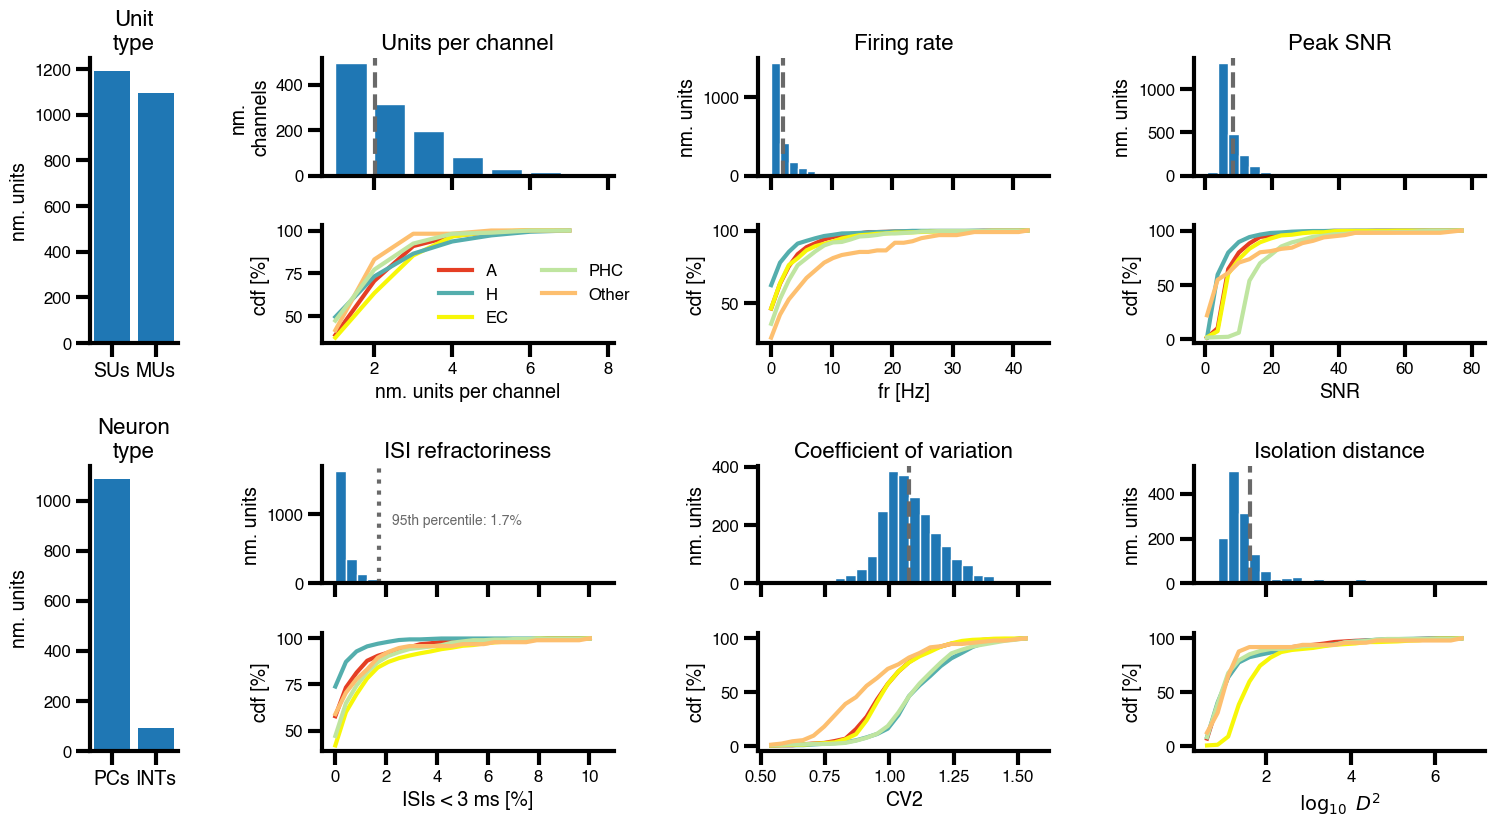

In [175]:
color_by_region = {
    "A": '#E53E24', 
    "H": '#54aead', 
    "EC": "#F7F708", 
    "PHC": '#bfe5a0', 
    "Other": '#fdbf6f',
}

fig = plt.figure(constrained_layout=False, figsize=(18, 9))
gs = fig.add_gridspec(nrows=5, ncols=4,
                       height_ratios=[1, 1, 0.2, 1, 1], 
                       width_ratios=[0.3, 1, 1, 1])

fig.subplots_adjust(hspace=0.5, wspace=0.6) 

# single-unit vs multi-units
ax0 = fig.add_subplot(gs[0:2, 0])

su, mu = count_su_mu(df_units_all)
ax0.bar([0,1], [su,mu])
ax0.set_title("Unit\ntype", fontsize=title_size_subplot)
ax0.set_xticks([0,1])
ax0.set_xticklabels(["SUs", "MUs"], fontsize=label_size)
ax0.set_ylabel("nm. units", fontsize=label_size)
sns.despine(ax=ax0)

# pyramidal cells vs interneurons
ax0 = fig.add_subplot(gs[3:, 0],)
pyramdials = (df_units_all["cell_type"] == "pyramidal").sum()
interneurons = (df_units_all["cell_type"] == "interneuron").sum()
ax0.bar([0,1], [pyramdials,interneurons],)
ax0.set_title("Neuron\ntype", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)
ax0.set_xticks([0,1])
ax0.set_xticklabels(["PCs", "INTs"], fontsize=label_size)

sns.despine(ax=ax0)


#############################

# units per channel

ax0 = fig.add_subplot(gs[0:1, 1:2])
ax1 = fig.add_subplot(gs[1:2, 1:2], sharex=ax0)
bins = np.arange(1, df_channelwise_units["channel_count"].max()+1,)
hists, bin_edges, cdf_region_dict = data_units_per_channel(df_channelwise_units, bins=bins)
ax0.bar(bin_edges[:-1], hists, width=0.8, align='edge', edgecolor='white')

## plot region-stratified cdf
for key, item in cdf_region_dict.items():
    ax1.plot(bin_edges[:-1], item, label=key, color=color_by_region[key], lw=3)

plot_mean(ax0, df_channelwise_units["channel_count"])

ax0.set_xticks(bins[1::2])

ax0.set_title("Units per channel", fontsize=title_size_subplot)
ax0.set_ylabel("nm.\nchannels", fontsize=label_size)

ax1.set_xlabel("nm. units per channel", fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)

sugar(ax0, ax1)
handle_legend(ax1)

# firing rate
b=30
ax0 = fig.add_subplot(gs[0:1, 2:3], )
ax1 = fig.add_subplot(gs[1:2, 2:3], sharex=ax0)

hists, bin_edges = np.histogram(df_units_all["fr_hz"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "fr_hz", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )
plot_mean(ax0, df_units_all["fr_hz"],)

ax0.set_title("Firing rate", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)
ax1.set_xlabel("fr [Hz]", fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)
sugar(ax0, ax1)

# spike peak SNR
b=25
ax0 = fig.add_subplot(gs[0:1, 3:4])
ax1 = fig.add_subplot(gs[1:2, 3:4], sharex=ax0)

hists, bin_edges = no_nan_histogram(df_units_all["peak_SNR"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "peak_SNR", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )
plot_mean(ax0, df_units_all["peak_SNR"],)

ax0.set_title("Peak SNR", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)
ax1.set_xlabel("SNR", fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)
sugar(ax0, ax1)


# ISI violations
ax0 = fig.add_subplot(gs[3:4, 1:2])
ax1 = fig.add_subplot(gs[4:, 1:2], sharex=ax0)

hists, bin_edges = np.histogram(df_units_all["isi_violations"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "isi_violations", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )
m = np.percentile(df_units_all["isi_violations"], 95)
ax0.axvline(m, ls=':', lw=lw_summary_stat, color=stat_line_color)
ax0.text(m+0.5, ax0.get_ylim()[1]*0.5, f"95th percentile: {m:.1f}%", color=stat_line_color)

ax0.set_title("ISI refractoriness", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)

ax1.set_xlabel("ISIs < 3 ms [%]", fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)
sugar(ax0, ax1)

ax0.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# CV2
ax0 = fig.add_subplot(gs[3:4, 2:3])
ax1 = fig.add_subplot(gs[4:, 2:3], sharex=ax0)

hists, bin_edges = no_nan_histogram(df_units_all["cv2"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "cv2", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )
plot_mean(ax0, df_units_all["cv2"],)

ax0.set_title("Coefficient of variation", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)
ax1.set_xlabel("CV2", fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)
sugar(ax0, ax1)


# isolation distance
ax0 = fig.add_subplot(gs[3:4, 3:4])
ax1 = fig.add_subplot(gs[4:, 3:4], sharex=ax0)

df_units_all.loc[df_units_all["iso_dist"] > 1e11, "iso_dist"] = np.nan # hacky work-around for buggy filter, fix
hists, bin_edges = no_nan_histogram(np.log10(df_units_all["iso_dist"]), b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "iso_dist", b, log=True)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )
plot_mean(ax0, np.log10(df_units_all["iso_dist"]),)

ax0.set_title("Isolation distance", fontsize=title_size_subplot)
ax0.set_ylabel("nm. units", fontsize=label_size)
ax1.set_xlabel(r'$\log_{10}$ $D^{2}$', fontsize=label_size)
ax1.set_ylabel("cdf [%]", fontsize=label_size)
sugar(ax0, ax1)


plt.savefig(panel_save_dir / "fig_spike_sorting.png", bbox_inches="tight", dpi=300)
plt.savefig(panel_save_dir / "fig_spike_sorting.svg", bbox_inches="tight", dpi=300)
plt.show()

In [197]:
## Caption Stats

# a
print("a")
print("SUs Count:", su)
print("MUs Count:", mu)

# b
print("\nb")
print("PCs count:", pyramdials)
print("INTs count:", interneurons)

# c
print("\nc")
print("Mean units per channel:", np.mean(df_channelwise_units["channel_count"]))
print("SEM units per channel:", np.std(df_channelwise_units["channel_count"]) / np.sqrt(len(df_channelwise_units)))  # sem

# d
print("\nd")
print("Mean firing rate [Hz]:", np.mean(df_units_all["fr_hz"]))
print("SEM firing rate [Hz]:", np.std(df_units_all["fr_hz"]) / np.sqrt(len(df_units_all)))  # sem

# e
print("\ne")
print("Mean peak SNR:", np.nanmean(df_units_all["peak_SNR"]))
print("SEM peak SNR:", np.nanstd(df_units_all["peak_SNR"]) / np.sqrt(len(df_units_all) - df_units_all["peak_SNR"].isna().sum()))  # sem

# f 
print("\nf")
print("95% percentile ISI violations [%]:", np.percentile(df_units_all["isi_violations"], 95))
print("Mean ISI violations [%]:", np.nanmean(df_units_all["isi_violations"]))
print("SEM ISI violations [%]:", np.nanstd(df_units_all["isi_violations"]) / np.sqrt(len(df_units_all) - df_units_all["isi_violations"].isna().sum()))  # sem

# g
print("\ng")
print("Mean CV2:", np.nanmean(df_units_all["cv2"]))
print("SEM CV2:", np.nanstd(df_units_all["cv2"]) / np.sqrt(len(df_units_all) - df_units_all["cv2"].isna().sum()))  #

# h
print("\nh")
iso_dist = df_units_all[df_units_all["iso_dist"].notna()]
print("Nm. of isolation distance values:", len(iso_dist))
print("Median isolation distance:", np.median(iso_dist["iso_dist"]))

a
SUs Count: 1190
MUs Count: 1096

b
PCs count: 1086
INTs count: 91

c
Mean units per channel: 2.023008849557522
SEM units per channel: 0.035347328113379026

d
Mean firing rate [Hz]: 1.9284623250912938
SEM firing rate [Hz]: 0.06307923084417168

e
Mean peak SNR: 8.19439157644915
SEM peak SNR: 0.1037888448756008

f
95% percentile ISI violations [%]: 1.723179223349384
Mean ISI violations [%]: 0.41520467133410965
SEM ISI violations [%]: 0.013922483232501358

g
Mean CV2: 1.0779441663554596
SEM CV2: 0.0025845176868734055

h
Nm. of isolation distance values: 1395
Median isolation distance: 21.82414015608153
